# Product Recognition on Store Shelves

**Nicola Carrassi - ID. 0001037813 - nicola.carrassi@studio.unibo.it**

<br>

In this notebook, the topic of object recognition will be adressed. For this task, an approach based on the local invariant features paradigm has been developed. <br>

## Libraries Import and definition of parameters

In this section I will import the libraries needed and define some parameters and objects that will be used later in the code

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from shapely.geometry import box, mapping
import warnings



warnings.filterwarnings("ignore")

In [2]:
# Parameters definition

MODELS_PATH = os.path.join(os.getcwd(), "models")
SCENES_PATH = os.path.join(os.getcwd(), "scenes")

FLANN_INDEX_KDTREE = 1
LOWE_RATIO_TR = 0.55

N_TREES = 5
N_CHECKS = 50

MIN_MATCH_COUNT = 50
COLOR_DIFF_TR = 50


sift = cv2.xfeatures2d.SIFT_create()

index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=N_TREES)
search_params = dict(checks = N_CHECKS)
matcher = cv2.FlannBasedMatcher(index_params, search_params)


## Functions for the object retrieval algorithm

In order to make the code more readable, it has been splitted in several functions which are then used, so it is possible to avoid replication of the code and divide the responsibility of each procedure. <br>
This has been done to respect software engineering princples.  

In [3]:
def load_RGBimg(image_path: str):
  """
  The function allows to load an image and convert it in the RGB
  color format. This is because using openCV2 the loaded image
  is in the BGR format. 

  :param image_path: Path of the image we want to load

  :return Image in the RGB format.
  """
  img = cv2.imread(image_path, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  return img


def learn_features(image_path: str, image_name: str):
    """
    The function allows to obtain the keypoints and associated descriptors
    of a given image.

    :param image_path: path of the image we want to obtain the keypoints and descriptors
    :param image_name: name of the image, its identifier

    :return
        :image_name: identifier of the image
        :keyPoints: List of the keypoints for the given image
        :descriptors: List of the descriptors associated to the keypoints

    """
    img = load_RGBimg(image_path)
   
    if img is None:
        print("Image not found!")
        return None
        
    keyPoints  = sift.detect(img)
    keyPoints, descriptors = sift.compute(img, keyPoints) 

    return (image_name, keyPoints, descriptors)

In [4]:
def keypoint_clustering(kp, quantile):
  """
  The function allows to cluster the keypoints of a given image.
   

  :param kp: List of keypoints
  :quantile:  desired level of quantile to use for the bandwidth estimation 

  :return Tuple containing the labels of the clusters for each keypoint and the number of clusters

  """
  x = [point.pt[0] for point in kp]
  x = np.array(x).reshape(-1, 1)

  bw = estimate_bandwidth(x, quantile=quantile)

  mean_shift = MeanShift(bandwidth=bw, cluster_all=True, bin_seeding=True) # bin_seeding True to speed up the process 

  mean_shift.fit(x)

  n_clusters = len(np.unique(mean_shift.labels_))

  return mean_shift.labels_, n_clusters



def get_roi(x, y, img):
  """
  The function allows to obtain the bounding box of the region of interest
  and the portion of the original image which contains the objects, given the
  coordinates of the 4 corners

  :param x: x coordinates of the 4 corners
  :param y: y coordinates of the 4 corners
  :param img: image of which we want to get the ROI

  :return :
    :roi : region of interest in the original image
    :bb : bounding box of the roi in the original image, expressed as coordinates of the 
          top left and bottom right corner.
  """

  top_left_x = int(max(0, min(x) ))
  top_left_y = int(max(0, min(y) ))

  bottom_right_x = int(max(x))
  bottom_right_y = int(max(y))

  roi = img[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
  bb = ( (top_left_x, top_left_y) , (bottom_right_x, bottom_right_y) )   

  return roi, bb 


def nms(bounding_boxes, IoU_th= 0.2):
  """
  Non maxima suppression of the bounding boxes.


  :param bounding_boxes: List of bounding boxes
  :param IoU_th: Intersection over union threshold

  :return: List of non-maxima-suppressed bounding boxes
  """
  boxes = [box(tl[0], tl[1], br[0] , br[1] ) for tl, br in bounding_boxes]

  maxima = []

  boxes.sort(key = lambda x: x.area, reverse = True)

  while boxes:
    boxA = boxes.pop(0) # Take the largest element
    maxima.append(boxA)

    for boxB in boxes:
      intersection = boxA.intersection(boxB).area
      union  = boxB.union(boxB).area
      if intersection and union:
        IoU = intersection / union
        if IoU >= IoU_th:
          boxes.remove(boxB)
    
  return maxima

In [5]:
def get_obj_instances(bounding_boxes):
  
  instances= []  
  bounding_boxes = nms(bounding_boxes)
  
  if len(bounding_boxes):
    for index in range(len(bounding_boxes)):
      centroid = bounding_boxes[index].centroid
      bb = mapping(bounding_boxes[index])["coordinates"]
      bb = bb[0]

      top_left_corner = (int( bb[3][0]), int( bb[3][1] ))
      bottom_right_corner = (int( bb[1][0]), int( bb[1][1] ))

      obj = (top_left_corner, bottom_right_corner, centroid)
      instances.append(obj)

  return instances, bounding_boxes


def print_output(instances, prodID):
  if len(instances):
    print("Product {} - {} Instance(s) Found:".format(prodID,len(instances)))
        
    for index,bb in enumerate(instances):
      centroid = bb[-1]
      top_left_corner = bb[0]
      bottom_right_corner = bb[1] 

      height = bottom_right_corner[0] - top_left_corner[0] 
      width = bottom_right_corner[1] - top_left_corner[1]

      print("Instance {} [ position: (({},{}), width: {} px, height: {} px]".format(index+1,centroid.xy[0][0],centroid.xy[1][0],width,height))
        
  else:
      print("Product {} - No Istances Found".format(prodID))


In [6]:
def object_retrieval(model, train, model_img, train_img, quantile):
  """
  The function allows to retrieve one or more instances of a given model inside a 
  target image.

  :param model: object we are seeking to retrieve. It is a tuple composed in the following way:
                (name, keypoints, descriptors)
  :param train: image on which we want to find the model. It is a tuple as for model
  :param model_img: image of the model
  :param train_img: image of the training image
  :param quantile: quantile used for the clustering

  :return instances of the given object. An empty list in case the object is not in the image

  """


  model_idx = model[0]
  model_kp = model[1]
  model_descriptors = model[2]
  h, w, _  = model_img.shape

  train_idx = train[0]
  train_kp = train[1]
  train_descriptors = train[2]



  bounding_boxes = []



  labels, n_clusters = keypoint_clustering(train_kp, quantile)

                                   
  for i in range(n_clusters):
    # Compute matches

    key_train_cluster = np.array(train_kp)[labels == i]
    descr_train_cluster = np.array(train_descriptors)[labels == i]

    matches = matcher.knnMatch(model_descriptors, descr_train_cluster, 2) 
    
        
    #Store olnly the good matches
    good_matches = [m for m,n in matches if m.distance < LOWE_RATIO_TR * n.distance]


    if len(good_matches) > MIN_MATCH_COUNT:
      src_pts = np.float32([model_kp[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
      dst_pts = np.float32([key_train_cluster[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
      
      if M is None:
        print("No homography found")

      else:
        # Generate and plot the rectangle into the target image
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
      
        # Collect all the x and y coordinates 
        x = [dst[i][0][0] for i in range(4)]
        y = [dst[i][0][1] for i in range(4)]
        roi, bb = get_roi(x, y, train_img)

        if len(roi):
          # Color-based filtering
          roi_color = roi.mean(axis=0).mean(axis=0)
          img_color = model_img.mean(axis=0).mean(axis=0)
          color_diff = np.linalg.norm(roi_color - img_color)

          if color_diff < COLOR_DIFF_TR:
            bounding_boxes.append(bb)
            

  instances, bounding_boxes = get_obj_instances(bounding_boxes)
  print_output(instances, model_idx)


  return instances

## Procedure to test multiple instances iteratively

This procedure has been coded just to avoid repeating code for the different problems, since otherwise this code would have been replicated twice.


In [7]:
def process_scenes(scenes, models, scenes_extension='.png', models_extension=".jpg", quantile = 0.23):
  for scene in scenes:
    print("Processing scene: {}".format(scene[0]))
  

    scene_path = os.path.join(SCENES_PATH, scene[0] + scenes_extension) 
    scene_img = load_RGBimg(scene_path)

    objects = []

    for model in models:
      model_path = os.path.join(MODELS_PATH, model[0] + models_extension)
      model_img = load_RGBimg(model_path)
    
      if model_img is not None and scene_img is not None:
        obj = object_retrieval(model, scene, model_img, scene_img, quantile)
        if len(obj) > 0:
          objects += obj

    for obj in objects:
      cv2.rectangle(scene_img, obj[0], obj[1], (0,255,0), 4, cv2.LINE_AA)
    

    plt.figure()
    plt.imshow(scene_img)
    plt.show()
    print()


## Step A

The first step involves identifying a single instance of the product in the image. For this task we are given 7 models and 5 different images in which we should check if the model is in the image for each given model.

In [8]:
productIds = ["0","1","11","19","24","26","25"]
sceneIds = ["e1", "e2", "e3", "e4", "e5"]
models_extension = ".jpg"
scenes_extension = ".png"


models = [ learn_features(os.path.join(MODELS_PATH, pId + models_extension), pId) for pId in productIds]
scenes = [ learn_features(os.path.join(SCENES_PATH, scene + scenes_extension), scene) for scene  in sceneIds]

Processing scene: e1
Product 0 - 1 Instance(s) Found:
Instance 1 [ position: ((163.5,219.0), width: 438 px, height: 315 px]
Product 1 - No Istances Found
Product 11 - 1 Instance(s) Found:
Instance 1 [ position: ((441.0,182.5), width: 365 px, height: 302 px]
Product 19 - No Istances Found
Product 24 - No Istances Found
Product 26 - No Istances Found
Product 25 - No Istances Found


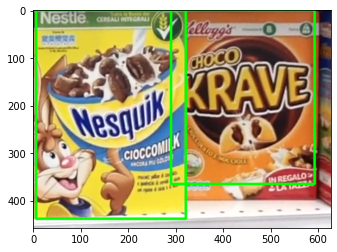


Processing scene: e2
Product 0 - No Istances Found
Product 1 - No Istances Found
Product 11 - No Istances Found
Product 19 - No Istances Found
Product 24 - 1 Instance(s) Found:
Instance 1 [ position: ((168.0,232.5), width: 465 px, height: 336 px]
Product 26 - 1 Instance(s) Found:
Instance 1 [ position: ((539.5,232.0), width: 464 px, height: 337 px]
Product 25 - 1 Instance(s) Found:
Instance 1 [ position: ((877.0,230.0), width: 446 px, height: 322 px]


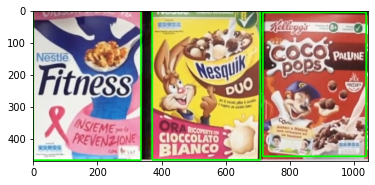


Processing scene: e3
Product 0 - 1 Instance(s) Found:
Instance 1 [ position: ((170.0,238.0), width: 452 px, height: 328 px]
Product 1 - 1 Instance(s) Found:
Instance 1 [ position: ((817.0,200.0), width: 400 px, height: 310 px]
Product 11 - 1 Instance(s) Found:
Instance 1 [ position: ((474.5,191.0), width: 382 px, height: 305 px]
Product 19 - No Istances Found
Product 24 - No Istances Found
Product 26 - No Istances Found
Product 25 - No Istances Found


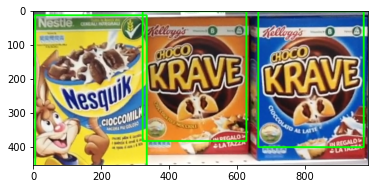


Processing scene: e4
Product 0 - 1 Instance(s) Found:
Instance 1 [ position: ((161.0,742.0), width: 452 px, height: 322 px]
Product 1 - No Istances Found
Product 11 - 1 Instance(s) Found:
Instance 1 [ position: ((463.5,690.0), width: 394 px, height: 305 px]
Product 19 - No Istances Found
Product 24 - No Istances Found
Product 26 - 1 Instance(s) Found:
Instance 1 [ position: ((204.0,222.0), width: 444 px, height: 344 px]
Product 25 - 1 Instance(s) Found:
Instance 1 [ position: ((567.5,323.0), width: 646 px, height: 423 px]


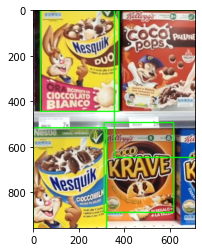


Processing scene: e5
Product 0 - No Istances Found
Product 1 - No Istances Found
Product 11 - No Istances Found
Product 19 - 1 Instance(s) Found:
Instance 1 [ position: ((503.0,191.5), width: 383 px, height: 300 px]
Product 24 - No Istances Found
Product 26 - No Istances Found
Product 25 - 1 Instance(s) Found:
Instance 1 [ position: ((184.0,321.0), width: 626 px, height: 368 px]


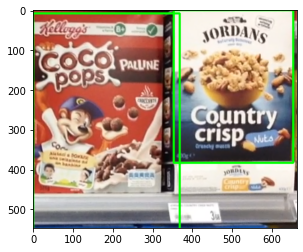

In [9]:
process_scenes(scenes, models)

## Step B

In the second step we have to detect also more than a single instance in a given image. For this task we use the same models as before but we have different images on which we should test our code.

Processing scene: m1
Product 0 - No Istances Found
Product 1 - No Istances Found
Product 11 - No Istances Found
Product 19 - No Istances Found
Product 24 - 2 Instance(s) Found:
Instance 1 [ position: ((184.5,232.5), width: 465 px, height: 363 px]
Instance 2 [ position: ((549.0,232.5), width: 465 px, height: 340 px]
Product 26 - 1 Instance(s) Found:
Instance 1 [ position: ((922.5,231.5), width: 463 px, height: 337 px]
Product 25 - 1 Instance(s) Found:
Instance 1 [ position: ((1259.5,230.0), width: 448 px, height: 323 px]


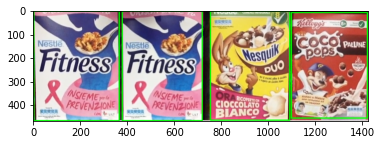


Processing scene: m2
Product 0 - 1 Instance(s) Found:
Instance 1 [ position: ((178.0,302.5), width: 463 px, height: 348 px]
Product 1 - 2 Instance(s) Found:
Instance 1 [ position: ((849.0,258.5), width: 413 px, height: 318 px]
Instance 2 [ position: ((1180.5,257.5), width: 415 px, height: 309 px]
Product 11 - 1 Instance(s) Found:
Instance 1 [ position: ((509.5,253.0), width: 406 px, height: 307 px]
Product 19 - No Istances Found
Product 24 - No Istances Found
Product 26 - No Istances Found
Product 25 - No Istances Found


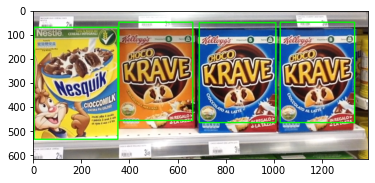


Processing scene: m3
Product 0 - No Istances Found
Product 1 - No Istances Found
Product 11 - No Istances Found
Product 19 - 1 Instance(s) Found:
Instance 1 [ position: ((1232.5,190.5), width: 381 px, height: 301 px]
Product 24 - No Istances Found
Product 26 - 1 Instance(s) Found:
Instance 1 [ position: ((193.0,230.0), width: 460 px, height: 364 px]
Product 25 - 2 Instance(s) Found:
Instance 1 [ position: ((897.5,324.0), width: 632 px, height: 413 px]
Instance 2 [ position: ((557.0,222.5), width: 445 px, height: 338 px]


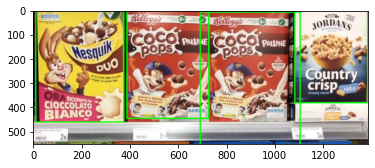


Processing scene: m4
Product 0 - No Istances Found
Product 1 - No Istances Found
Product 11 - No Istances Found
Product 19 - No Istances Found
Product 24 - 2 Instance(s) Found:
Instance 1 [ position: ((538.5,223.5), width: 447 px, height: 361 px]
Instance 2 [ position: ((175.5,224.0), width: 448 px, height: 351 px]
Product 26 - 1 Instance(s) Found:
Instance 1 [ position: ((920.0,222.0), width: 444 px, height: 344 px]
Product 25 - 2 Instance(s) Found:
Instance 1 [ position: ((1258.0,294.5), width: 589 px, height: 446 px]
Instance 2 [ position: ((1587.5,213.5), width: 427 px, height: 317 px]


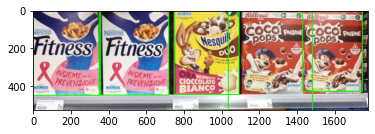


Processing scene: m5
Product 0 - No Istances Found
Product 1 - 2 Instance(s) Found:
Instance 1 [ position: ((501.0,721.0), width: 414 px, height: 316 px]
Instance 2 [ position: ((834.5,717.5), width: 415 px, height: 313 px]
Product 11 - 1 Instance(s) Found:
Instance 1 [ position: ((162.0,714.0), width: 406 px, height: 310 px]
Product 19 - 1 Instance(s) Found:
Instance 1 [ position: ((908.0,191.5), width: 383 px, height: 300 px]
Product 24 - No Istances Found
Product 26 - No Istances Found
Product 25 - 2 Instance(s) Found:
Instance 1 [ position: ((231.5,224.5), width: 449 px, height: 337 px]
Instance 2 [ position: ((562.5,229.0), width: 454 px, height: 327 px]


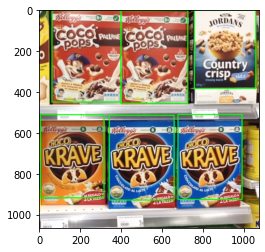

In [10]:
productIds = ["0","1","11","19","24","26","25"]
sceneIds = ["m1", "m2", "m3", "m4", "m5"]


models = [ learn_features(os.path.join(MODELS_PATH, pId + models_extension), pId) for pId in productIds]
scenes = [ learn_features(os.path.join(SCENES_PATH, scene + scenes_extension), scene) for scene  in sceneIds]

process_scenes(scenes, models, quantile=0.16 )